### Preparations

1. Downloading the [Galaxy10 Dataset](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html)

In [7]:
#!curl -l https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 -o 'Galaxy10.h5'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  20.8M      0  0:00:09  0:00:09 --:--:-- 24.4M


In [1]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor()])

2. Loading the galaxy images & labels from the downloaded file
3. Prepare image data (grayscale, crop, normalize)
4. Shuffle images & labels the same way

In [3]:
np.concatenate([np.arange(0, 5), np.arange(0,6)])

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5])

In [4]:
import h5py

# Get galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  images = np.array(F["images"])

# turn color into grayscale
images = images.mean(axis=-1, keepdims=True)
# crop the images 64x64 pixels
images = images[:, 2:66, 2:66, :]
# normalize intensity from 0...255 to 0...1.0
#images = images.astype(np.float32) / 255.

# shuffle once
shuffle_idx = np.random.default_rng(seed=123).permutation(len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

# create 60 copies of 17 images
# class_5_images = images[labels == 5]
# class_5_images_copies = np.repeat(class_5_images, 60, axis=0)
# images = np.concatenate([images, class_5_images_copies])
# # appending labels for them 
# labels = np.concatenate([labels, np.ones(17*60)*5])
# show shape
print(f"{images.shape=} {labels.shape=}")

images.shape=(21785, 64, 64, 1) labels.shape=(21785,)


(array([3461., 6997., 6292.,  349., 1534.,   17.,  589., 1121.,  906.,
         519.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

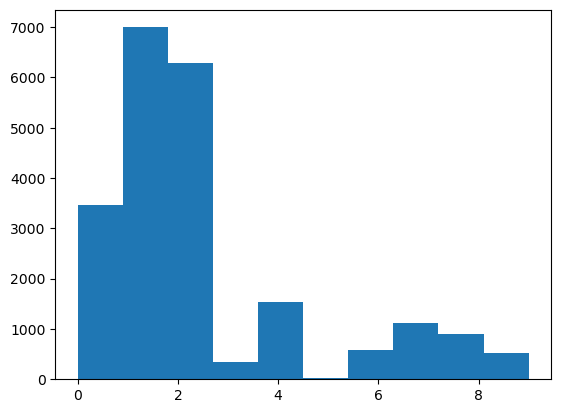

In [5]:
%matplotlib inline
plt.figure()
plt.hist(labels)

5. Two plotting helpers `show_galaxies` and `show_confusion` with usage example

## Primary Task:
- Train a neural network to classify the galaxy image’s shapes
- Invest some time into optimizing your network’s performance

## Questions:
1. How do you measure your network’s performance?
   - What is your reason for this choice?
   - What other good choices are there?
2. What makes Class 5 (Disk, Edge-on, Boxy Bulge) stand out?
   - How can this be addressed?
3. Find the galaxy images that your network performs best(worst) with. Explain why this is the case.

## Your solution

In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [36]:
torch.cuda.is_available()

True

In [37]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
images_swap = np.swapaxes(np.swapaxes(images, 3, 1), 2,3)
images_swap.shape

(21785, 1, 64, 64)

In [39]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = Image.fromarray(self.data[index][0].astype(np.uint8), 'L')
            x = self.transform(x)
        
        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y

In [62]:
galaxy_dataset = MyDataset(images_swap, labels, data_transform)
galaxy_dataset = TensorDataset(torch.Tensor(images_swap), torch.Tensor(labels))

In [63]:
import torch.nn as nn
from torch.nn.modules import Sigmoid

In [64]:
train_dataset, test_dataset = torch.utils.data.random_split(galaxy_dataset, [0.7, 0.3])

In [65]:
print(len(train_dataset), len(test_dataset))

15250 6535


In [66]:
loaders = {
    'train' : DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=1),
    'test' : DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=1)
    }

In [67]:
class LeonidCNN(nn.Module):
    def __init__(self):
        super(LeonidCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                padding=2,
            )
        self.sigmoid1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                out_channels=16,
                kernel_size=5,
                padding=0,)
        self.sigmoid2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3136, 120)
        self.sigmoid3 = nn.ReLU()
        self.linear2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.ReLU()
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.sigmoid3(x)
        x = self.linear2(x)
        x = self.sigmoid4(x)
        x = self.linear3(x)
        output = x
        return output

In [68]:
class LisaCNN(nn.Module):
    def __init__(self):
        super(LisaCNN, self).__init__()
        #TODO: define the layers

        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=(5,5),
                stride=1,
                padding=2
            )
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
            )
        self.conv2 = nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=(7,7),
                stride=1,
            )
        self.pool2 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
                )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2704, 120) #2704,120
        self.linear2 = nn.Linear(120,84) #120,84
        self.linear = nn.Linear(84,10)
        self.dropout = nn.Dropout()
        self.dropout20 = nn.Dropout(0.2)


    def forward(self, x):

        #TODO: run layer

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) ###
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.linear(x)
        #softmax ist in der loss funktion
        return output

In [69]:
class MathisCNN(nn.Module):
    def __init__(self):
        super(MathisCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=9,padding=0)
        self.sigmoid1 = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=7,padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=5,padding=0)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(54, 50)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)

        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        output = x
        return output

In [70]:
from torchviz import make_dot

In [71]:
cnn = LeonidCNN()
print(cnn)

LeonidCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3136, out_features=120, bias=True)
  (sigmoid3): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (sigmoid4): ReLU()
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [72]:
from torchsummary import summary
summary(cnn, (1,64,64), batch_size=2048, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2048, 6, 64, 64]             156
              ReLU-2          [2048, 6, 64, 64]               0
         AvgPool2d-3          [2048, 6, 32, 32]               0
            Conv2d-4         [2048, 16, 28, 28]           2,416
              ReLU-5         [2048, 16, 28, 28]               0
         AvgPool2d-6         [2048, 16, 14, 14]               0
           Flatten-7               [2048, 3136]               0
            Linear-8                [2048, 120]         376,440
              ReLU-9                [2048, 120]               0
           Linear-10                 [2048, 84]          10,164
             ReLU-11                 [2048, 84]               0
           Linear-12                 [2048, 10]             850
Total params: 390,026
Trainable params: 390,026
Non-trainable params: 0
-------------------------------

In [73]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
print(class_weights)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights = class_weights.to(device)

[  0.62944236   0.31134772   0.34623331   6.24212034   1.42014342
 128.14705882   3.69864177   1.94335415   2.40452539   4.19749518]


In [74]:
loss_func = nn.CrossEntropyLoss() #weight=class_weights)
loss_func

CrossEntropyLoss()

In [75]:
# move model to GPU
cnn = cnn.to(device)

In [76]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.005, weight_decay=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.001
)

In [77]:
def train(num_epochs, cnn, loaders):
    train_losses = []
    train_accuracy = []
    trainloader = loaders['train']
    testloader = loaders['test']
    val_losses = []
    val_accuracy = []
    # Train the model
    for epoch in range(num_epochs):
        cnn.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(loaders['train']):
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            # run model
            output = cnn(images)
            # compute loss function
            labels = labels.to(torch.int64)
            loss = loss_func(output, labels)
            # save metrics for ploting
            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply update
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)


        cnn.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = cnn(images)
                labels = labels.to(torch.int64)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 25
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, cnn, loaders)

Epoch: 1/25 | loss: 2.8730520606040955 - acc: 0.19399082846939564 | val_loss: 2.244623064994812 - val_acc: 0.16201446577906609
Epoch: 2/25 | loss: 2.1916598677635193 - acc: 0.15739123709499836 | val_loss: 2.0466811060905457 - val_acc: 0.15942788496613503
Epoch: 3/25 | loss: 1.8411879390478134 - acc: 0.3012450896203518 | val_loss: 1.8772158324718475 - val_acc: 0.3139208257198334
Epoch: 4/25 | loss: 1.746637761592865 - acc: 0.32391397655010223 | val_loss: 1.7257961332798004 - val_acc: 0.3225931227207184
Epoch: 5/25 | loss: 1.6865120977163315 - acc: 0.3222614862024784 | val_loss: 1.6642564535140991 - val_acc: 0.3288649171590805
Epoch: 6/25 | loss: 1.6497325003147125 - acc: 0.3216455243527889 | val_loss: 1.6424279510974884 - val_acc: 0.3035910502076149
Epoch: 7/25 | loss: 1.6187797635793686 - acc: 0.31692658364772797 | val_loss: 1.6027524173259735 - val_acc: 0.32903381437063217
Epoch: 8/25 | loss: 1.5747080892324448 - acc: 0.33997971192002296 | val_loss: 1.5567314624786377 - val_acc: 0.377

In [78]:
torch.save(cnn.state_dict(), 'leonid_cnn_no_aug_no_data_repeat.pt')

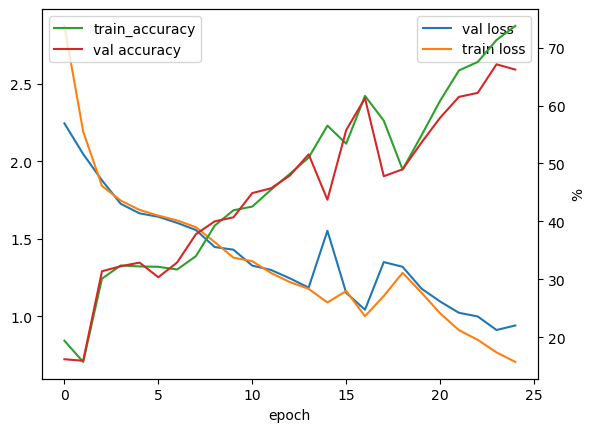

In [79]:
%matplotlib inline
plt.figure()
plt.plot(val_losses, label='val loss', color='C0')
plt.plot(train_losses, label='train loss', color='C1')

plt.legend()
plt.xlabel('epoch')
ax1 = plt.twinx()
ax1.plot(np.array(train_accuracy)*100, label='train_accuracy', color='C2')
ax1.plot(np.array(val_accuracy)*100, label='val accuracy', color='C3')

ax1.set_ylabel('%')
ax1.legend()
plt.savefig('loss_over_epoch_no_aug.png', dpi=400)

In [80]:
def test(cnn, loaders):
    test_prediction_list = []
    test_label_list = []
    # Test the model
    cnn.eval()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output = cnn(images)
            pred_labels = torch.max(test_output, dim=1)[1]
            test_prediction_list.append(pred_labels)
            test_label_list.append(labels)
    test_label = torch.cat(test_label_list)
    test_prediction = torch.cat(test_prediction_list)
    return test_label.cpu(), test_prediction.cpu()

test_label, test_prediction = test(cnn, loaders)

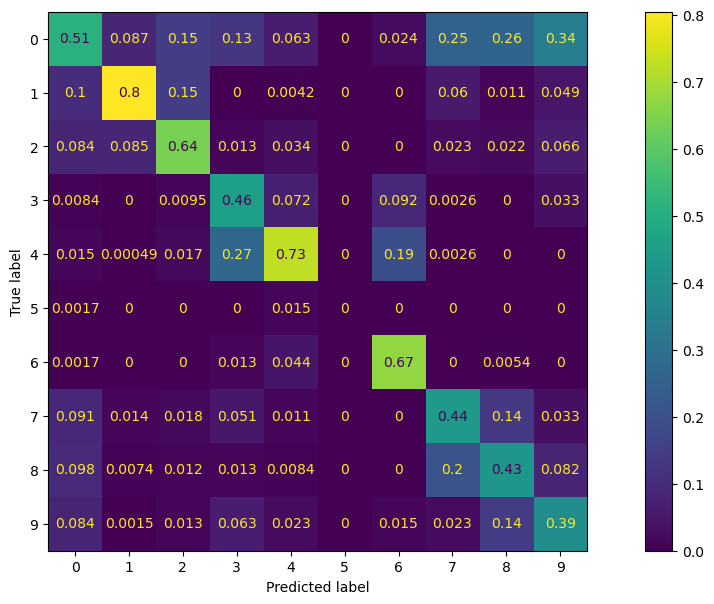

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix and normalizes it over predicted (columns)
confusion = confusion_matrix(test_label.numpy(), test_prediction.numpy(), normalize='pred')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion).plot(ax=ax)
plt.savefig('leonidCNN_2048_batch_size_no_aug.png', dpi=400)
plt.show()

# Mathis

In [112]:
loaders = {
    'train' : DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=1),
    'test' : DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=1)
    }

In [113]:
import torch.nn as nn
from torch.nn.modules import Sigmoid

In [114]:
class LeonidCNN(nn.Module):
    def __init__(self):
        super(LeonidCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                padding=2,
            )
        self.sigmoid1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                out_channels=16,
                kernel_size=5,
                padding=0,)
        self.sigmoid2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3136, 120)
        self.sigmoid3 = nn.ReLU()
        self.linear2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.ReLU()
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.sigmoid3(x)
        x = self.linear2(x)
        x = self.sigmoid4(x)
        x = self.linear3(x)
        output = x
        return output

In [115]:
class LisaCNN(nn.Module):
    def __init__(self):
        super(LisaCNN, self).__init__()
        #TODO: define the layers

        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=(5,5),
                stride=1,
                padding=2
            )
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
            )
        self.conv2 = nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=(7,7),
                stride=1,
            )
        self.pool2 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
                )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2704, 120) #2704,120
        self.linear2 = nn.Linear(120,84) #120,84
        self.linear = nn.Linear(84,10)
        self.dropout = nn.Dropout()
        self.dropout20 = nn.Dropout(0.2)


    def forward(self, x):

        #TODO: run layer

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) ###
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.linear(x)
        #softmax ist in der loss funktion
        return output

In [116]:
class MathisCNN(nn.Module):
    def __init__(self):
        super(MathisCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=9,padding=0)
        self.sigmoid1 = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=7,padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=5,padding=0)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(54, 50)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)

        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        output = x
        return output

In [117]:
cnn = MathisCNN()
print(cnn)

MathisCNN(
  (conv1): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
  (sigmoid1): Sigmoid()
  (relu): ReLU()
  (pool1): AvgPool2d(kernel_size=4, stride=2, padding=0)
  (conv2): Conv2d(6, 6, kernel_size=(7, 7), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (conv3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=54, out_features=50, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [118]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
print(class_weights)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights = class_weights.to(device)

[0.65891361 0.3259254  0.36244437 6.53438395 1.48663625 2.19913211
 3.87181664 2.03434434 2.51710817 4.39402697]


In [119]:
loss_func = nn.CrossEntropyLoss() #weight=class_weights)
loss_func

CrossEntropyLoss()

In [120]:
# move model to GPU
cnn = cnn.to(device)

In [121]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.005, weight_decay=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.001
)

In [122]:
def train(num_epochs, cnn, loaders):
    train_losses = []
    train_accuracy = []
    trainloader = loaders['train']
    testloader = loaders['test']
    val_losses = []
    val_accuracy = []
    # Train the model
    for epoch in range(num_epochs):
        cnn.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(loaders['train']):
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            # run model
            output = cnn(images)
            # compute loss function
            labels = labels.to(torch.int64)
            loss = loss_func(output, labels)
            # save metrics for ploting
            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply update
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)


        cnn.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = cnn(images)
                labels = labels.to(torch.int64)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 50
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, cnn, loaders)

Epoch: 1/50 | loss: 1.8879138380289078 - acc: 0.2792517626658082 | val_loss: 1.7870713983263289 - val_acc: 0.28293466567993164
Epoch: 2/50 | loss: 1.7516967356204987 - acc: 0.3070386806502938 | val_loss: 1.6971555948257446 - val_acc: 0.3016062378883362
Epoch: 3/50 | loss: 1.638950102031231 - acc: 0.3283399501815438 | val_loss: 1.5467858144215174 - val_acc: 0.35219292981284006
Epoch: 4/50 | loss: 1.5058958008885384 - acc: 0.3838209072127938 | val_loss: 1.4198193039212907 - val_acc: 0.4138272213084357
Epoch: 5/50 | loss: 1.3998621553182602 - acc: 0.42828634567558765 | val_loss: 1.3568851436887468 - val_acc: 0.4380399371896471
Epoch: 6/50 | loss: 1.3701840229332447 - acc: 0.43813954293727875 | val_loss: 1.357067687170846 - val_acc: 0.4342309662273952
Epoch: 7/50 | loss: 1.3513541035354137 - acc: 0.4446862265467644 | val_loss: 1.3145281757627214 - val_acc: 0.4624736074890409
Epoch: 8/50 | loss: 1.3474829383194447 - acc: 0.44641378708183765 | val_loss: 1.3410767572266715 - val_acc: 0.446310

In [107]:
torch.save(cnn.state_dict(), 'mathiscnn.pt')


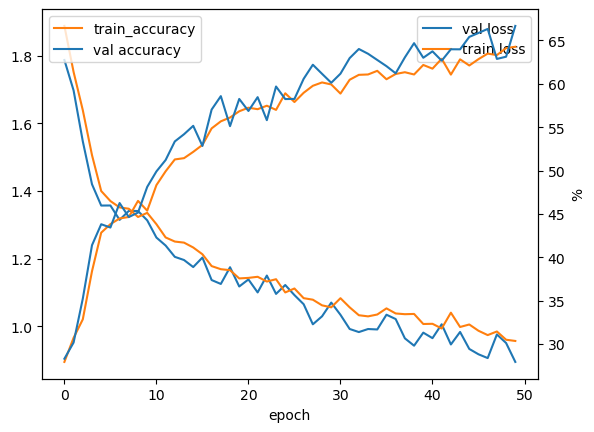

In [123]:
%matplotlib inline
plt.figure()
plt.plot(val_losses, label='val loss', color='C0')
plt.plot(train_losses, label='train loss', color='C1')

plt.legend()
plt.xlabel('epoch')
ax1 = plt.twinx()
ax1.plot(np.array(train_accuracy)*100, label='train_accuracy', color='C2')
ax1.plot(np.array(val_accuracy)*100, label='val accuracy', color='C0')

ax1.set_ylabel('%')
ax1.legend()
plt.savefig('loss_over_epoch_mathiscnn.png', dpi=400)

In [124]:
def test(cnn, loaders):
    test_prediction_list = []
    test_label_list = []
    # Test the model
    cnn.eval()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output = cnn(images)
            pred_labels = torch.max(test_output, dim=1)[1]
            test_prediction_list.append(pred_labels)
            test_label_list.append(labels)
    test_label = torch.cat(test_label_list)
    test_prediction = torch.cat(test_prediction_list)
    return test_label.cpu(), test_prediction.cpu()

test_label, test_prediction = test(cnn, loaders)

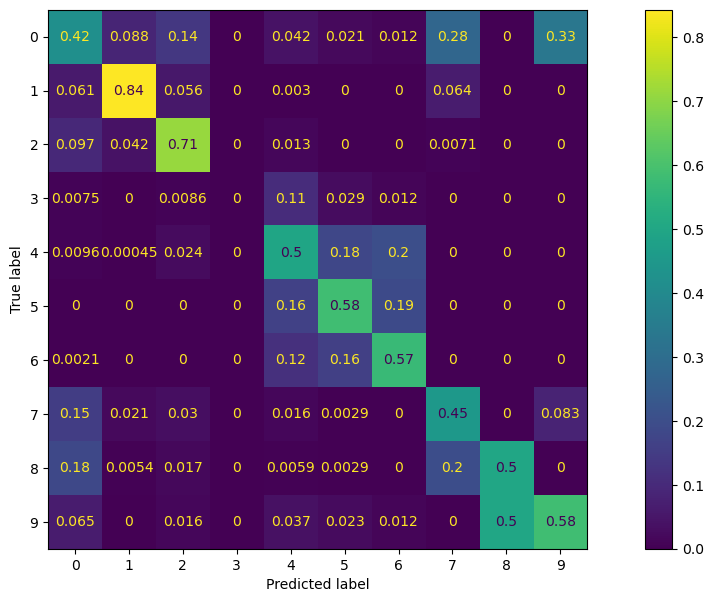

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix and normalizes it over predicted (columns)
confusion = confusion_matrix(test_label.numpy(), test_prediction.numpy(), normalize='pred')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion).plot(ax=ax)
plt.savefig('mathiscnn_512_batch_size.png', dpi=400)
plt.show()

# Weights

In [140]:
train_dataset, test_dataset = torch.utils.data.random_split(galaxy_dataset, [0.7, 0.3])

In [157]:
loaders = {
    'train' : DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=1),
    'test' : DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=1)
    }

In [158]:
class LeonidCNN(nn.Module):
    def __init__(self):
        super(LeonidCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                padding=2,
            )
        self.sigmoid1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                out_channels=16,
                kernel_size=5,
                padding=0,)
        self.sigmoid2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3136, 120)
        self.sigmoid3 = nn.ReLU()
        self.linear2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.ReLU()
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.sigmoid3(x)
        x = self.linear2(x)
        x = self.sigmoid4(x)
        x = self.linear3(x)
        output = x
        return output

In [159]:
class LisaCNN(nn.Module):
    def __init__(self):
        super(LisaCNN, self).__init__()
        #TODO: define the layers

        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=(5,5),
                stride=1,
                padding=2
            )
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
            )
        self.conv2 = nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=(7,7),
                stride=1,
            )
        self.pool2 = nn.AvgPool2d(
                kernel_size=(2,2),
                stride=2,
                )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2704, 120) #2704,120
        self.linear2 = nn.Linear(120,84) #120,84
        self.linear = nn.Linear(84,10)
        self.dropout = nn.Dropout()
        self.dropout20 = nn.Dropout(0.2)


    def forward(self, x):

        #TODO: run layer

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) ###
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.linear(x)
        #softmax ist in der loss funktion
        return output

In [160]:
class MathisCNN(nn.Module):
    def __init__(self):
        super(MathisCNN, self).__init__()
        #TODO: define the layers
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=9,padding=0)
        self.sigmoid1 = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=7,padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=5,padding=0)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(54, 50)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)

        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        output = x
        return output

In [161]:
cnn = LeonidCNN()
print(cnn)

LeonidCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3136, out_features=120, bias=True)
  (sigmoid3): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (sigmoid4): ReLU()
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [162]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
print(class_weights)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights = class_weights.to(device)

[0.65891361 0.3259254  0.36244437 6.53438395 1.48663625 2.19913211
 3.87181664 2.03434434 2.51710817 4.39402697]


In [163]:
loss_func = nn.CrossEntropyLoss()# weight=class_weights)
loss_func

CrossEntropyLoss()

In [164]:
# move model to GPU
cnn = cnn.to(device)

In [165]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.005, weight_decay=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.001
)

In [ ]:
def train(num_epochs, cnn, loaders):
    train_losses = []
    train_accuracy = []
    trainloader = loaders['train']
    testloader = loaders['test']
    val_losses = []
    val_accuracy = []
    # Train the model
    for epoch in range(num_epochs):
        cnn.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(loaders['train']):
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            # run model
            output = cnn(images)
            # compute loss function
            labels = labels.to(torch.int64)
            loss = loss_func(output, labels)
            # save metrics for ploting
            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply update
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)


        cnn.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = cnn(images)
                labels = labels.to(torch.int64)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 200
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, cnn, loaders)

Epoch: 1/200 | loss: 2.010138362646103 - acc: 0.2636439800262451 | val_loss: 1.9067118167877197 - val_acc: 0.31170523166656494
Epoch: 2/200 | loss: 1.855861634016037 - acc: 0.2886430509388447 | val_loss: 1.8099743723869324 - val_acc: 0.3126516714692116
Epoch: 3/200 | loss: 1.8037099838256836 - acc: 0.3108595497906208 | val_loss: 1.7681867480278015 - val_acc: 0.31059153378009796
Epoch: 4/200 | loss: 1.7592580914497375 - acc: 0.3071836419403553 | val_loss: 1.72270268201828 - val_acc: 0.30962250381708145
Epoch: 5/200 | loss: 1.7021511495113373 - acc: 0.30623842030763626 | val_loss: 1.6545770168304443 - val_acc: 0.3205636441707611
Epoch: 6/200 | loss: 1.6306999027729034 - acc: 0.35608210042119026 | val_loss: 1.5572076737880707 - val_acc: 0.38240373134613037
Epoch: 7/200 | loss: 1.5316718071699142 - acc: 0.39626842737197876 | val_loss: 1.454132854938507 - val_acc: 0.41400645673274994
Epoch: 8/200 | loss: 1.457495078444481 - acc: 0.41975511610507965 | val_loss: 1.3903664946556091 - val_acc: 

In [171]:
torch.save(cnn.state_dict(), 'leonid_cnn_with_without_weight_batchsize_2048_200_epochs.pt')


0.7827157229185104


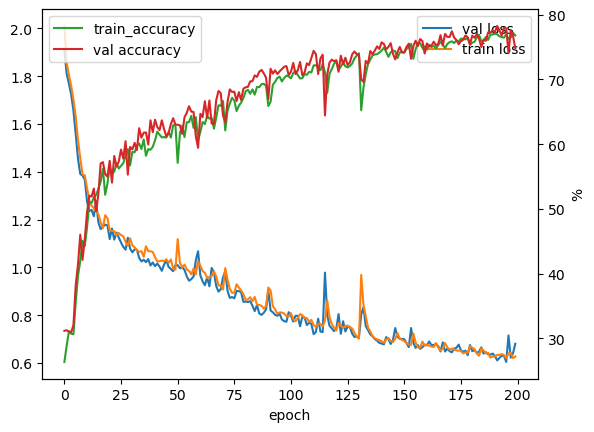

In [176]:
%matplotlib inline
plt.figure()
plt.plot(val_losses, label='val loss', color='C0')
plt.plot(train_losses, label='train loss', color='C1')

plt.legend()
plt.xlabel('epoch')
ax1 = plt.twinx()
ax1.plot(np.array(train_accuracy)*100, label='train_accuracy', color='C2')
ax1.plot(np.array(val_accuracy)*100, label='val accuracy', color='C3')
print(np.max(val_accuracy))
ax1.set_ylabel('%')
ax1.legend()
plt.savefig('loss_over_epoch_without_weights_batchsize_2048_78_percent.png', dpi=400)

In [177]:
def test(cnn, loaders):
    test_prediction_list = []
    test_label_list = []
    # Test the model
    cnn.eval()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output = cnn(images)
            pred_labels = torch.max(test_output, dim=1)[1]
            test_prediction_list.append(pred_labels)
            test_label_list.append(labels)
    test_label = torch.cat(test_label_list)
    test_prediction = torch.cat(test_prediction_list)
    return test_label.cpu(), test_prediction.cpu()

test_label, test_prediction = test(cnn, loaders)

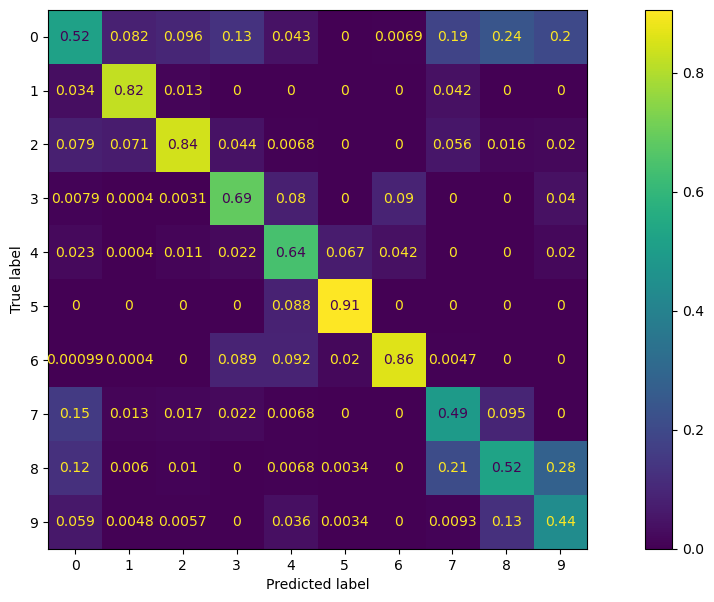

In [178]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix and normalizes it over predicted (columns)
confusion = confusion_matrix(test_label.numpy(), test_prediction.numpy(), normalize='pred')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion).plot(ax=ax)
plt.savefig('leonidCNN_2048_batch_size_without_weights_78_percent.png', dpi=400)
plt.show()